In [1]:
# import data
from datetime import datetime
begin = datetime.now()
import pandas as pd
import numpy as np
test = pd.read_csv('test.csv/test.csv')
test = pd.DataFrame(test)
## data=data.dropna(subset=['title','text'])
test['title'] = test['title'].astype("string")
test["text"] = test["text"].astype("string")
# test["author"] = test["author"].astype("string")

test = test.fillna(' ')
# # check data
print(test.shape)
test.head(10)

test.drop('author', axis = 1, inplace= True)

# making dictionary {id:text}
text_dict = {}
for i in range(0, len(test)):
    text_dict[test.id[i]] = test.text[i] #using text 
    
    

test_dict_for_lda = text_dict

(5200, 4)


In [2]:
len(test_dict_for_lda)

5200

In [3]:
test.head()

,id,title,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...","PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...","If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),42 mins ago 1 Views 0 Comments 0 Likes 'For th...


# LDA


In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
from wordcloud import WordCloud

def display_topic(words_probabilities):
    bows = []
    [bows.extend([word] * (int(probability*100) + 1)) for word,probability in words_probabilities]
    wordcloud = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate(' '.join(bows))
    plt.figure(figsize=[3,3])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

In [5]:
n_topics = 5

In [6]:
import gensim
docs = [[token.lower() for token in gensim.utils.tokenize(gensim.parsing.preprocessing.remove_stopwords(doc))] for doc in test_dict_for_lda.values()]
vocab = gensim.corpora.Dictionary(docs)
bow_corpus = [vocab.doc2bow(doc) for doc in docs]
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics = n_topics, id2word = vocab, passes = 10, workers = 2)

In [7]:
all_topics = lda_model.get_document_topics(bow_corpus, minimum_probability=0.0)
all_topics_csr = gensim.matutils.corpus2csc(all_topics)
all_topics_numpy = all_topics_csr.T.toarray()
all_topics_df = pd.DataFrame(all_topics_numpy)

In [8]:
all_topics_df

,0,1,2,3,4
0,0.139402,0.622803,0.237274,0.000259,0.000262
1,0.001371,0.001374,0.001369,0.001363,0.994523
2,0.000460,0.765377,0.000458,0.000452,0.233252
3,0.114019,0.470876,0.413952,0.000575,0.000579
4,0.042078,0.003290,0.692740,0.003269,0.258623
...,...,...,...,...,...
5195,0.337932,0.000114,0.594980,0.000113,0.066862
5196,0.248479,0.749724,0.000603,0.000593,0.000600
5197,0.628420,0.190024,0.180868,0.000342,0.000346
5198,0.000850,0.000848,0.000851,0.000837,0.996614


In [9]:
lda_model.show_topic(0)

[('s', 0.01626743),
 ('i', 0.013259636),
 ('the', 0.010916235),
 ('said', 0.008380658),
 ('it', 0.008032858),
 ('t', 0.005676163),
 ('like', 0.004633201),
 ('people', 0.0045510065),
 ('in', 0.0036484452),
 ('new', 0.003578169)]

In [10]:
lda_model.print_topics()

[(0,
  '0.016*"s" + 0.013*"i" + 0.011*"the" + 0.008*"said" + 0.008*"it" + 0.006*"t" + 0.005*"like" + 0.005*"people" + 0.004*"in" + 0.004*"new"'),
 (1,
  '0.024*"s" + 0.016*"mr" + 0.015*"said" + 0.012*"the" + 0.008*"trump" + 0.006*"i" + 0.005*"president" + 0.005*"it" + 0.004*"he" + 0.004*"in"'),
 (2,
  '0.019*"s" + 0.015*"i" + 0.012*"trump" + 0.011*"clinton" + 0.009*"the" + 0.008*"t" + 0.007*"it" + 0.006*"hillary" + 0.005*"election" + 0.004*"people"'),
 (3,
  '0.023*"la" + 0.014*"el" + 0.012*"en" + 0.011*"que" + 0.011*"del" + 0.009*"y" + 0.006*"por" + 0.005*"al" + 0.005*"los" + 0.005*"de"'),
 (4,
  '0.016*"s" + 0.014*"the" + 0.005*"russia" + 0.005*"us" + 0.005*"war" + 0.005*"government" + 0.005*"said" + 0.004*"it" + 0.004*"world" + 0.004*"syria"')]

In [11]:
def format_topics_sentences(ldamodel=lda_model, corpus=bow_corpus, texts=docs):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = " ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=bow_corpus, texts=docs)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.6228,s mr said the trump i president it he in,"[palo, alto, calif, after, years, scorning, po..."
1,1,4.0,0.9945,s the russia us war government said it world s...,"[russian, warships, ready, strike, terrorists,..."
2,2,1.0,0.7654,s mr said the trump i president it he in,"[videos, nodapl, native, american, leaders, vo..."
3,3,1.0,0.4708,s mr said the trump i president it he in,"[if, don, t, succeed, try, different, sport, t..."
4,4,2.0,0.6925,s i trump clinton the t it hillary election pe...,"[mins, ago, views, comments, likes, for, time,..."
5,5,2.0,0.8135,s i trump clinton the t it hillary election pe...,"[trump, usa, s, antique, hero, clinton, presid..."
6,6,2.0,0.5985,s i trump clinton the t it hillary election pe...,"[sunday, nbc, s, meet, press, house, minority,..."
7,7,1.0,0.7944,s mr said the trump i president it he in,"[you, here, home, articles, bound, weekly, fea..."
8,8,4.0,0.5074,s the russia us war government said it world s...,"[urban, population, booms, will, make, climate..."
9,9,2.0,0.7968,s i trump clinton the t it hillary election pe...,"[don, t, receipt]"


In [12]:
# Visualize the topics
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, vocab)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.092596  0.023474       1        1  38.894633
0     -0.052138 -0.071505       2        1  21.855171
2     -0.071617 -0.074374       3        1  19.293820
4     -0.062875  0.120022       4        1  17.860564
3      0.279226  0.002383       5        1   2.095813, topic_info=         Term          Freq         Total Category  logprob  loglift
455     trump  13358.000000  13358.000000  Default  30.0000  30.0000
72    clinton   6114.000000   6114.000000  Default  29.0000  29.0000
263        mr  17120.000000  17120.000000  Default  28.0000  28.0000
198         i  19829.000000  19829.000000  Default  27.0000  27.0000
8619       la   1209.000000   1209.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
618       com    111.121479   1361.486264   Topic5  -6.0954   1.3595
439       the    159.381695  26430.053589   Topic5  -5.7347  -1.2457
655     force    100.287046   1108.351216   Topic5  -6.1980   1.4626
377         s    135.602030  45697.525960   Topic5  -5.8963  -1.9548
2284     life     92.774291   1983.750707   Topic5  -6.2759   0.8027

[461 rows x 6 columns], token_table=       Topic      Freq   Term
term                         
8647       1  0.910790  _____
8647       2  0.004121  _____
8647       3  0.035030  _____
8647       4  0.051515  _____
0          1  0.473272      a
...      ...       ...    ...
7431       5  0.021862      à
4813       2  0.418174      в
4813       3  0.576692      в
4813       4  0.003890      в
18243      3  0.988338    все

[1097 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3, 5, 4])

In [13]:
df_dominant_topic.shape

C:\Users\fchua\miniconda3\envs\tensorflow\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(5200, 5)

In [14]:
df_dominant_topic.to_csv('lda_test_text_5.csv', index=False)

C:\Users\fchua\miniconda3\envs\tensorflow\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\fchua\miniconda3\envs\tensorflow\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


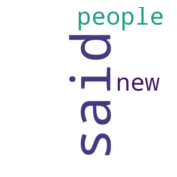

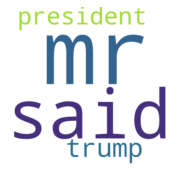

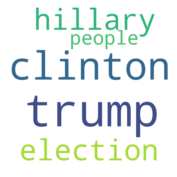

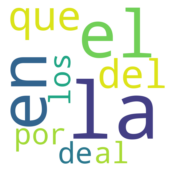

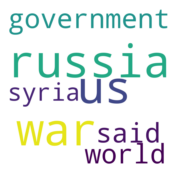

In [15]:
for topic_no in range(n_topics):
    display_topic(lda_model.show_topic(topic_no))